In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers
from keras import backend as K
from keras import Sequential, Input
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt

import math

from utils.constants import CLASSES, IMAGE_SIZE
from utils.load_dataset import load_dataset

In [2]:
# make the result reproducible
keras.utils.set_random_seed(42)

In [3]:
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - negro, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [5]:
DIRPATH = './data'
X_train, X_test, y_train, y_test = load_dataset(DIRPATH)

## Building a model

Testing LeNet-5 Architecture

In [6]:
from functools import partial

conv_regularizer = regularizers.l2(0.0006124219567560658)
dense_regularizer = regularizers.l2(0.03011157028527752)

activation_def = 'tanh'

# {'conv_regularizer': 0.0006124219567560658, 'dense_regularizer': 0.03011157028527752, 'dropout_1': 0.3433425343566813, 'dropout_2': 0.1625206873530064, 'dropout_3': 0.019169937499455086}.

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=5, padding="same", activation=activation_def,
                        kernel_regularizer=conv_regularizer) # kernel_initializer="he_normal")

model = Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    DefaultConv2D(6),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Dropout(0.3433425343566813),
    DefaultConv2D(16),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Dropout(0.1625206873530064),
    DefaultConv2D(120),

    layers.Flatten(),
    layers.Dropout(0.019169937499455086),
    layers.Dense(84, activation=activation_def, kernel_regularizer=dense_regularizer),
    layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 16)          0

In [7]:
# def get_lr_metric(optimizer):
#   def lr(y_true, y_pred):
#     return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
#   return lr

# lr_metric = get_lr_metric(optimizer)
# model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy", lr_metric])


optimizer = Adam(learning_rate=0.001)
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

In [8]:
# def step_decay(epoch):
#   initial_lrate = 0.1
#   drop = 0.9
#   epochs_drop = 10.0
#   lrate = initial_lrate * math.pow(drop,  
#           math.floor((1+epoch)/epochs_drop))
#   return lrate
 
# lrate_scheduler_callback = LearningRateScheduler(step_decay)

## Training Preparation

In [9]:
CHECKPOINT_PATH = 'models/checkpoints/famous48_test_model_v2_best.keras'

In [10]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

In [11]:
%%time
batch_size = 200
epochs = 100

history = model.fit(
  X_train, y_train,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
  # callbacks=[model_checkpoint_callback, lrate_scheduler_callback]
)

Epoch 1/100
22/22 [==============================] - 3s 22ms/step - loss: 6.3005 - accuracy: 0.0565 - val_loss: 4.4307 - val_accuracy: 0.0512
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 3.7762 - accuracy: 0.1635 - val_loss: 3.2106 - val_accuracy: 0.2495
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 3.0656 - accuracy: 0.2833 - val_loss: 2.7797 - val_accuracy: 0.3739
Epoch 4/100
22/22 [==============================] - 0s 10ms/step - loss: 2.7683 - accuracy: 0.3599 - val_loss: 2.5625 - val_accuracy: 0.3976
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 2.5774 - accuracy: 0.4081 - val_loss: 2.3971 - val_accuracy: 0.4470
Epoch 6/100
22/22 [==============================] - 0s 10ms/step - loss: 2.4351 - accuracy: 0.4417 - val_loss: 2.3208 - val_accuracy: 0.4580
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 2.3334 - accuracy: 0.4671 - val_loss: 2.1984 - val_accuracy: 0.4909
Epoch 

In [12]:
length = len(history.history['accuracy'])
print("train set accuracy:", round(history.history['accuracy'][length-1], 3))
print("train loss:", round(history.history['loss'][length-1], 3))
print("validation set accuracy:", round(history.history['val_accuracy'][length-1], 3))
print("validation set loss:", round(history.history['val_loss'][length-1], 3))

train set accuracy: 0.841
train loss: 0.995
validation set accuracy: 0.81
validation set loss: 1.118


In [13]:
results = model.evaluate(X_test, y_test)
print("test set accuracy:", round(results[1], 3))
print("test set loss:", round(results[0], 3))

43/43 [==============================] - 0s 3ms/step - loss: 1.1149 - accuracy: 0.8091
test set accuracy: 0.809
test set loss: 1.115


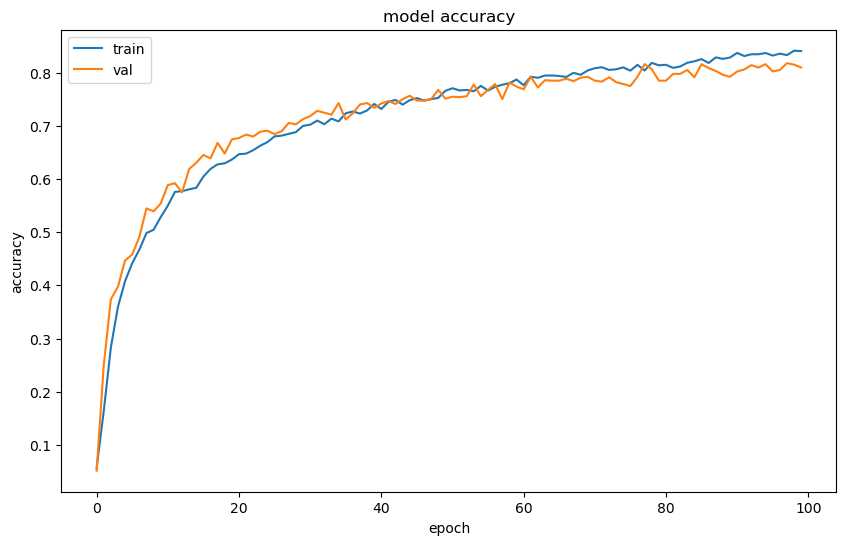

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()